# Разработка рекуррентной нейронной сети

<u>Цель</u> настоящей работы состоит в том, чтобы построить архитектур  рекуррентных нейронных сетей, которые позволяют решить практическую задачу с высокими показателями качества.

Для выполнения данной работы мной были выбраны библиотеки TensorFlow + Keras.

Данная работа состоит из частей.
1. <u>Загрузка библиотек </u> В данной части были загружены, а в случае необходмости, установлены необходмые библиотеки. Также зафиксированы рандомные значения, а также технические функции.  
2. <u>Предварительный просмотр и анализ данных </u>Предварительный просмотр данных, их колличества и содержания.
3. <u>Подготовка данных </u> Загрузка данных, создание датесета и загрузчика данных. Разработка программ/скриптов для подготовки тренировочных и тестовых данных.
4. <u>Разработка и обучение нейронных сетей</u> Разработаны 4 архитектуры нейроных сетей.

<u>Вывод</u>

## Часть 1. Загрузка необходмых библиотек

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Input, Attention, Concatenate, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from  wordcloud import WordCloud
import time

In [60]:
# Загрузка ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Инициализация стоп-слов и стеммера
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Часть 2. Предобработка и анализ данных

У нас есть один датасет, содержащий сведенья о новости, полное ее описание,заголовок, котегорию, краткое описание, ссылку на расположение и дату расположения новости

In [61]:
df=pd.read_json('/content/News_Category_Dataset_v3.json',lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Проведем предобработку текста:
- приведем его к нижнему регистру,
- разобьем на отдельные слова (токены),
- удалим небуквенно-цифровые символы и стоп-слова,
- применим стеммер Портера к оставшимся словам, чтобы получить их основу.

In [62]:
def preprocess_text(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text if processed_text.strip() else None

df['text'] = df['headline'].apply(preprocess_text)

Для целей данной работы оставляем только таргет и полное описание новости.

In [63]:
df = df[['text', 'category']]
df.head(3)

,text,category
0,4 million american roll sleev covid booster,U.S. NEWS
1,american airlin flyer charg ban life punch fli...,U.S. NEWS
2,23 funniest tweet cat dog week,COMEDY


In [64]:
print("Проверка пропущенных значений:")
print(f"Пропущенные тексты (text): {df['text'].isna().sum()}")
print(f"Пропущенные категории (category): {df['category'].isna().sum()}")

Проверка пропущенных значений:
Пропущенные тексты (text): 141
Пропущенные категории (category): 0


После предобработки текста, 141 значение оказалось пустям. Это строки, которые либо были пустыми изначально, либо содержали только стоп-слова. Данные строки могут быть удалены.

In [65]:
df = df.dropna(subset=['text', 'category'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209386 entries, 0 to 209526
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      209386 non-null  object
 1   category  209386 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


209 386 строк. Посмотрим на распределение категорий.


Степень несбалансированности:
U.S. NEWS: 0.66% записей
COMEDY: 2.58% записей
PARENTING: 4.19% записей
WORLD NEWS: 1.58% записей
CULTURE & ARTS: 0.51% записей
TECH: 1.00% записей
SPORTS: 2.42% записей
ENTERTAINMENT: 8.29% записей
POLITICS: 17.00% записей
WEIRD NEWS: 1.33% записей
ENVIRONMENT: 0.69% записей
EDUCATION: 0.48% записей
CRIME: 1.70% записей
SCIENCE: 1.05% записей
WELLNESS: 8.55% записей
BUSINESS: 2.86% записей
STYLE & BEAUTY: 4.69% записей
FOOD & DRINK: 3.03% записей
MEDIA: 1.41% записей
QUEER VOICES: 3.03% записей
HOME & LIVING: 2.06% записей
WOMEN: 1.70% записей
BLACK VOICES: 2.19% записей
TRAVEL: 4.73% записей
MONEY: 0.84% записей
RELIGION: 1.23% записей
LATINO VOICES: 0.54% записей
IMPACT: 1.66% записей
WEDDINGS: 1.74% записей
COLLEGE: 0.55% записей
PARENTS: 1.89% записей
ARTS & CULTURE: 0.64% записей
STYLE: 1.08% записей
GREEN: 1.25% записей
TASTE: 1.00% записей
HEALTHY LIVING: 3.19% записей
THE WORLDPOST: 1.75% записей
GOOD NEWS: 0.67% записей
WORLDPOST: 1.23% записей


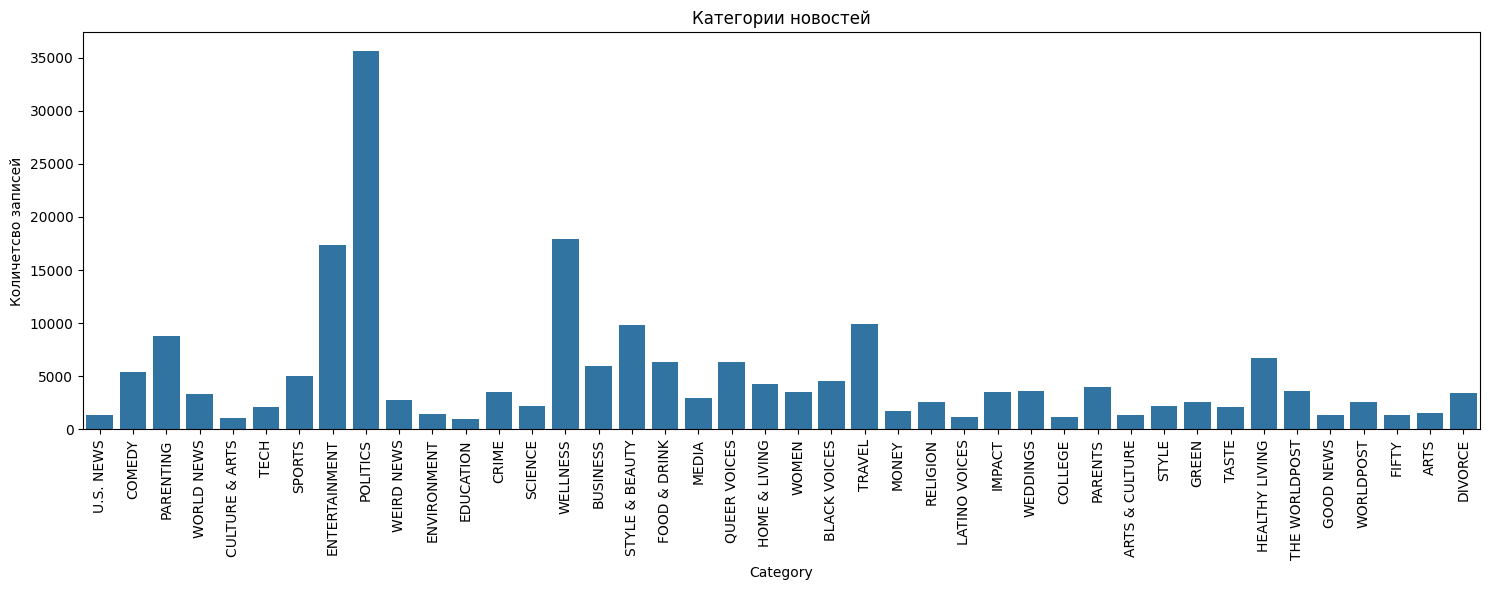

In [66]:
all_categories = df['category'].tolist()
category_counts = Counter(all_categories)

total_records = len(df)
print("\nСтепень несбалансированности:")
for category, count in category_counts.items():
    percentage = (count / total_records) * 100
    print(f"{category}: {percentage:.2f}% записей")

# График распределения категорий
plt.figure(figsize=(15, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title("Категории новостей")
plt.xlabel("Category")
plt.ylabel("Количетсво записей")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Распределение крайне неравномерно. Некоторых категорий катастроыфически мало, что будет препятстовать модели хорошо выучиться их распознать. Для целей настоящей работы в дальнейшем уберем самые редкие классы, оставив только 10 самых многочисленных классов.


Статистика длины текстов (в словах):
Средняя длина: 6.45
Медиана длины: 6.00
Максимальная длина: 36
Минимальная длина: 1


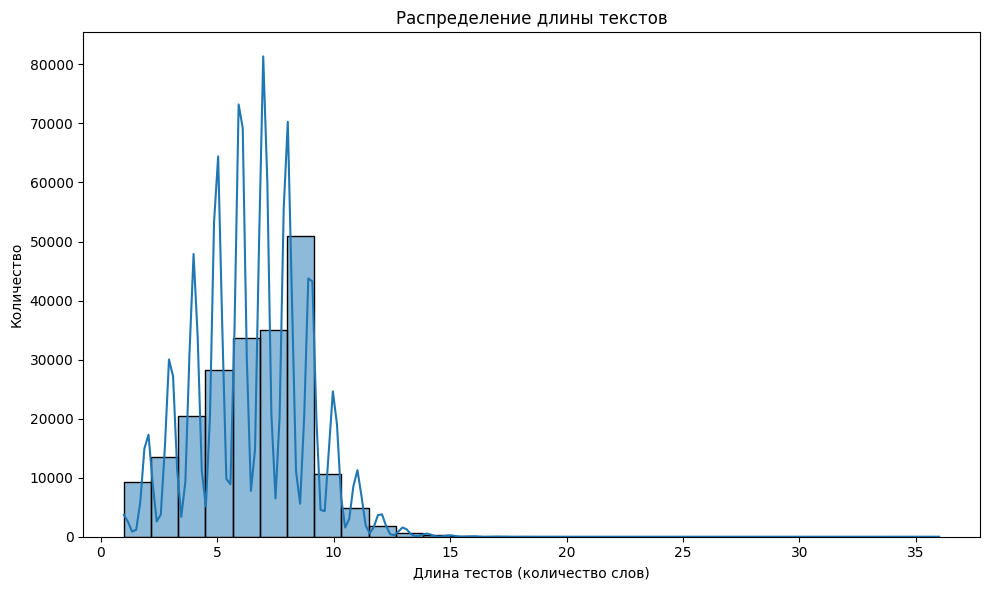

In [67]:
df['text_length'] = df['text'].apply(lambda x: len(word_tokenize(str(x))))
print("\nСтатистика длины текстов (в словах):")
print(f"Средняя длина: {df['text_length'].mean():.2f}")
print(f"Медиана длины: {df['text_length'].median():.2f}")
print(f"Максимальная длина: {df['text_length'].max()}")
print(f"Минимальная длина: {df['text_length'].min()}")

# График распределения длины текстов
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Распределение длины текстов")
plt.xlabel("Длина тестов (количество слов)")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

Новости довольно короткие, в основном 5-10 слов. Сложным моделям вряд ли смогут выявить зависимости, поэтому будет использовать только простые модели.

In [68]:
df[df['text_length']==1]

,text,category,text_length
5002,flu,POLITICS,1
6243,financ,MONEY,1
13649,flipsid,TECH,1
16154,babi,PARENTS,1
17505,opinion,POLITICS,1
...,...,...,...
208981,beverag,FOOD & DRINK,1
209021,wheel,HOME & LIVING,1
209075,judg,WELLNESS,1
209411,sucker,WELLNESS,1


Очень не уверена, что новость из одного слова является на самом деле новостью. И хотя таких строк довольно много, стоит их удалить.

In [69]:
df = df[df['text_length']>1]


Топ-20 наиболее частых слов:
trump: 13998 раз
photo: 12369 раз
new: 8905 раз
video: 6203 раз
say: 6069 раз
get: 5378 раз
make: 5324 раз
day: 5322 раз
donald: 4829 раз
way: 4114 раз
best: 3722 раз
year: 3666 раз
show: 3512 раз
women: 3478 раз
5: 3457 раз
world: 3370 раз
kid: 3244 раз
time: 3222 раз
one: 3157 раз
10: 3113 раз


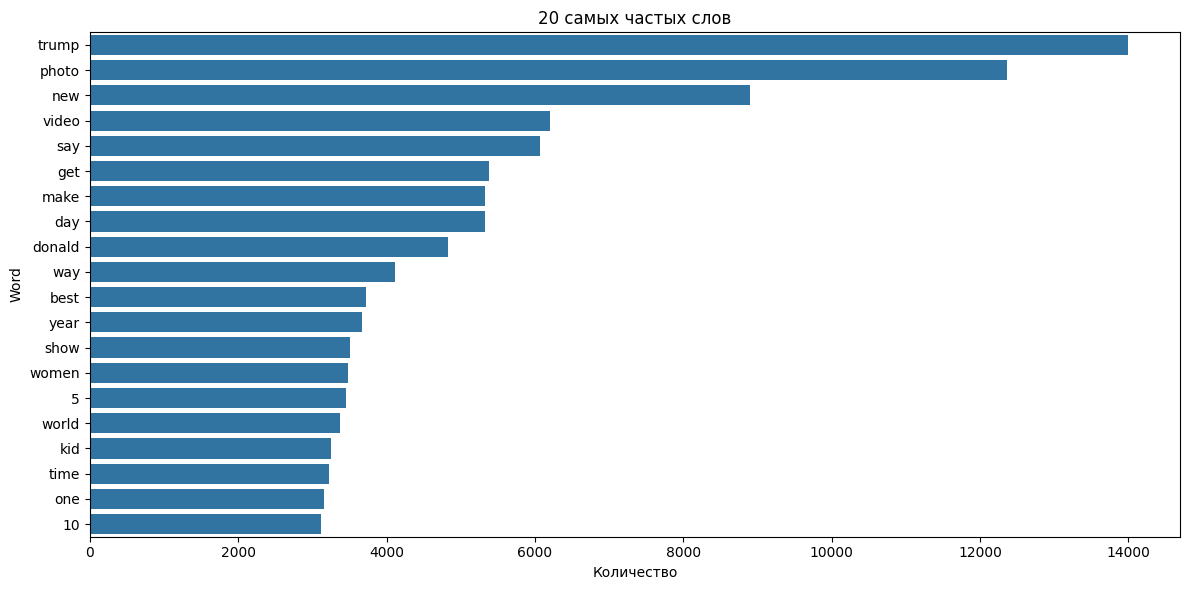

In [70]:
def preprocess_text_for_analysis(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

all_words = []
for text in df['text']:
    all_words.extend(preprocess_text_for_analysis(text))

word_counts = Counter(all_words)
print("\nТоп-20 наиболее частых слов:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count} раз")

# График топ-20 слов
top_words = dict(word_counts.most_common(20))
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
plt.title("20 самых частых слов")
plt.xlabel("Количество")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

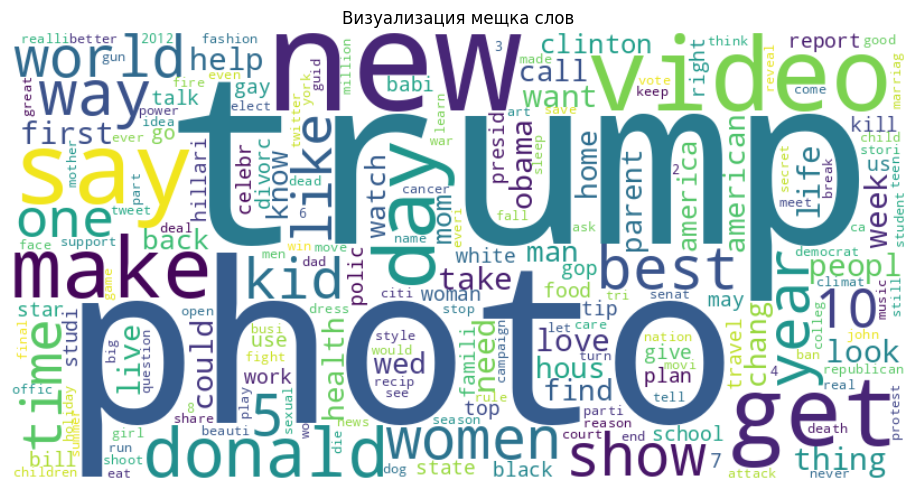

In [71]:
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Визуализация мешка слов")
plt.tight_layout()
plt.show()

Очень много слов не несущих какой-либо значимый смысл отдельно от контекста.

## Часть 3. Подготовка данных


Размер датасета после фильтрации: 123678 записей

Распределение категорий после фильтрации:
PARENTING: 8613 записей
ENTERTAINMENT: 17328 записей
POLITICS: 35450 записей
WELLNESS: 17486 записей
BUSINESS: 5969 записей
STYLE & BEAUTY: 9786 записей
FOOD & DRINK: 6310 записей
QUEER VOICES: 6304 записей
TRAVEL: 9853 записей
HEALTHY LIVING: 6579 записей


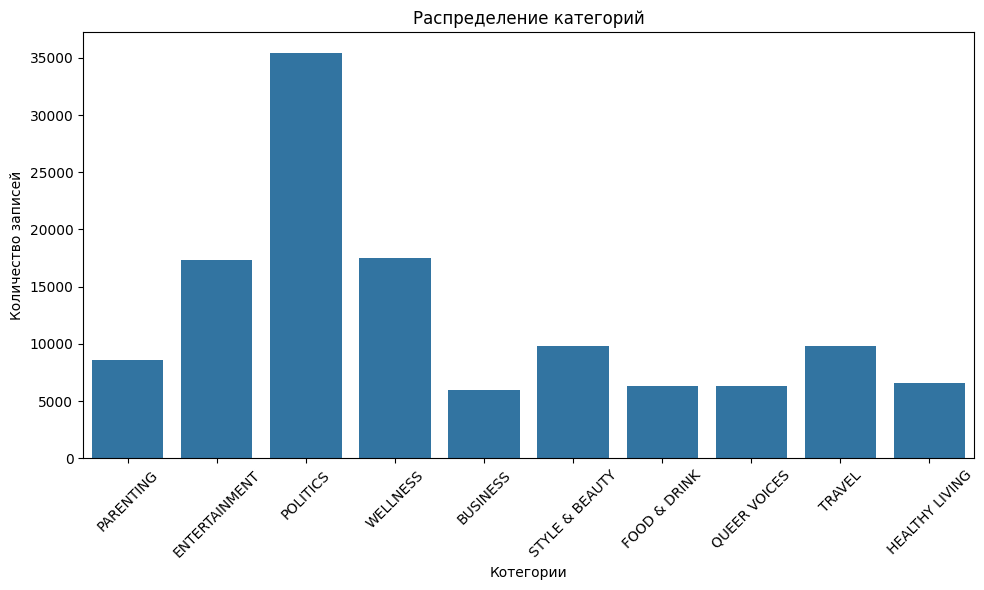

In [72]:
# Выбираем 10 самых многочисленных классов
top_10_categories = [category for category, count in category_counts.most_common(10)]

df = df[df['category'].isin(top_10_categories)]
print(f"\nРазмер датасета после фильтрации: {len(df)} записей")

category_counts = Counter(df['category'].tolist())
print("\nРаспределение категорий после фильтрации:")
for category, count in category_counts.items():
    print(f"{category}: {count} записей")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title("Распределение категорий")
plt.xlabel("Котегории")
plt.ylabel("Количество записей")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Распределение также крайне неравномерное. Стоит применить аугментацию к тренировочному датасету, а также обрезать многочисленные классы.

In [73]:
# введем гиперпараметры
vocab_size = 20000
max_length = 40
embedding_dim = 100
num_categories = len(top_10_categories)

Токенизируем данные.

In [74]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

Кодируем таргет

In [75]:
le = LabelEncoder()
y = le.fit_transform(df['category'])

Разделяем на train, val и test

In [76]:
X_train, X_val_test, y_train, y_val_test = train_test_split(padded_sequences, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [77]:
print(f"Размер валидационного набора: {len(X_val)}")
print(f"Размер тренировочного набора: {len(X_train)}")
print(f"Размер тестового набора: {len(X_test)}")

Размер валидационного набора: 18552
Размер тренировочного набора: 86574
Размер тестового набора: 18552


Проведем аугментацию тренировочного набора данных. В связи с распределением ограничем количество записей  9 000 для каждой категории.

In [78]:
train_df = pd.DataFrame({'text': [row for row in X_train], 'category': y_train})
train_category_counts = Counter(train_df['category'].tolist())
print("\nРаспределение категорий в тренировочном наборе до аугментации:")
for category_idx, count in train_category_counts.items():
    category_name = le.inverse_transform([category_idx])[0]
    print(f"{category_name}: {count} записей")


Распределение категорий в тренировочном наборе до аугментации:
ENTERTAINMENT: 12117 записей
POLITICS: 24779 записей
PARENTING: 6046 записей
BUSINESS: 4155 записей
WELLNESS: 12387 записей
HEALTHY LIVING: 4541 записей
FOOD & DRINK: 4444 записей
TRAVEL: 6865 записей
STYLE & BEAUTY: 6853 записей
QUEER VOICES: 4387 записей


In [79]:
target_size = 9000
augmented_X_train = []
augmented_y_train = []
total_added = 0
total_removed = 0

for category_idx in range(num_categories):
    category_df = train_df[train_df['category'] == category_idx]
    current_count = len(category_df)

    if current_count > target_size:
        category_df = category_df.sample(n=target_size, random_state=42)
        total_removed += (current_count - target_size)
    elif current_count < target_size:
        needed = target_size - current_count
        while needed > 0:
            to_add = min(needed, current_count)
            sampled_df = category_df.sample(n=to_add, replace=True, random_state=42)
            X_sampled = np.array([row for row in sampled_df['text'].values], dtype=np.float32)
            y_sampled = np.array([category_idx] * to_add, dtype=np.int32)
            augmented_X_train.append(X_sampled)
            augmented_y_train.append(y_sampled)
            total_added += to_add
            needed -= to_add
    X_current = np.array([row for row in category_df['text'].values], dtype=np.float32)
    y_current = np.array(category_df['category'].values, dtype=np.int32)
    augmented_X_train.append(X_current)
    augmented_y_train.append(y_current)

augmented_X_train = np.concatenate(augmented_X_train, axis=0).astype(np.float32)
augmented_y_train = np.concatenate(augmented_y_train, axis=0).astype(np.int32)

print(f"\nУдалено записей при обрезании: {total_removed}")
print(f"Добавлено записей в процессе аугментации: {total_added}")
print(f"Размер тренировочного набора после аугментации: {len(augmented_X_train)} записей")

X_train = augmented_X_train
y_train = augmented_y_train


Удалено записей при обрезании: 22283
Добавлено записей в процессе аугментации: 25709
Размер тренировочного набора после аугментации: 90000 записей


In [80]:
# Устройство для обучения
device = tf.config.list_physical_devices('GPU')
if device:
    print("Using GPU for training")
else:
    print("Using CPU for training")

Using CPU for training


 ## Часть 4. Моделиование

Определяем модели. Испрльзуем простую сверточную сеть, плюс три разных рекурентных сетей.

Первая модель - это одномерная сверточная нейронную сеть (1D CNN). Модель начинается со слоя эмбеддинга, преобразующего слова в векторные представления. Затем идет четыре последовательных сверточных слоя (Conv1D) с уменьшающимся количеством фильтров и размером ядра, каждый из которых сопровождается нормализацией данных (BatchNormalization) и функцией активации ReLU. После сверточных слоев применяется глобальное макс-пулингование (GlobalMaxPooling1D) для уменьшения размерности. Далее следуют два полносвязных слоя (Dense) с ReLU активацией, L2 регуляризацией и нормализацией  с Dropout для предотвращения переобучения. Финальный полносвязный слой имеет функцию активации softmax для получения вероятностей классов.

In [81]:
# CNN
def build_cnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Conv1D(filters=16, kernel_size=2, activation='relu'),
        BatchNormalization(),
        Conv1D(filters=8, kernel_size=2, activation='relu'),
        BatchNormalization(),
        Conv1D(filters=4, kernel_size=2, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_categories, activation='softmax')
    ])
    return model

Вторая модель - это рекурентная нейронная сеть. Эта функция строит модель с двумя слоями GRU и механизмом внимания (Attention). Модель начинается со слоя эмбеддинга. Затем два последовательных слоя GRU обрабатывают последовательность, причём второй GRU выдаёт все промежуточные состояния. Слой внимания взвешивает различные части выходных данных второго GRU, выделяя наиболее важные моменты. Результат внимания проходит через слой глобального макс-пулинга. Далее следует полносвязный слой с ReLU активацией и L2 регуляризацией, за которым идут нормализация данных и Dropout. Финальный полносвязный слой с активацией softmax выдает вероятности классов.

In [82]:
def build_gru_attention_model():
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim)(inputs)
    gru_out1 = GRU(128, return_sequences=True)(embedding)
    gru_out2 = GRU(32, return_sequences=True)(gru_out1)
    attention = Attention()([gru_out2, gru_out2])
    context = GlobalMaxPooling1D()(attention)
    dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(context)
    batch_norm = BatchNormalization()(dense)
    dropout = Dropout(0.6)(batch_norm)
    outputs = Dense(num_categories, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Третья модель тоже рекурентная нейронная сеть. Эта функция создает модель для классификации последовательностей, использующую двунаправленный LSTM и механизм внимания. Сначала входные данные проходят через слой эмбеддинга. Затем двунаправленный LSTM обрабатывает последовательность в обоих направлениях, улавливая контекст как до, так и после каждого элемента. Слой внимания взвешивает выходные данные LSTM, выделяя наиболее важные части. Результат внимания подвергается глобальному макс-пулингу. Далее следуют два полносвязных слоя с ReLU активацией, L2 регуляризацией, нормализацией данных и Dropout для предотвращения переобучения. Финальный полносвязный слой с активацией softmax выдает вероятности классов.

In [83]:
def build_lstm_attention_model():
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim)(inputs)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = Attention()([lstm_out, lstm_out])
    context = GlobalMaxPooling1D()(attention)
    dense1 = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(context)
    batch_norm = BatchNormalization()(dense1)
    dropout = Dropout(0.6)(batch_norm)
    dense2 = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(dropout)
    batch_norm2 = BatchNormalization()(dense2)
    outputs = Dense(num_categories, activation='softmax')(batch_norm2)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Четвертая модель - третья рекурентная сеть. Эта функция строит модель на основе двух двунаправленных GRU-слоев (BiGRU) для классификации последовательностей. Сначала входные данные проходят через слой эмбеддинга. Затем два последовательных слоя BiGRU обрабатывают последовательность в обоих направлениях. Первый BiGRU возвращает все промежуточные состояния, а второй — только последнее. После каждого BiGRU следует слой нормализации данных. Далее идет полносвязный слой с ReLU активацией и L2 регуляризацией, за которым следуют нормализация данных и Dropout. Финальный полносвязный слой с активацией softmax выдает вероятности классов.

In [84]:
def build_bigru_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Bidirectional(GRU(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.1)),
        BatchNormalization(),
        Bidirectional(GRU(16, return_sequences=False, dropout=0.3, recurrent_dropout=0.1)),
        BatchNormalization(),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(num_categories, activation='softmax')
    ])
    return model

In [85]:
models = {
    "CNN": build_cnn_model(),
    "GRU_Attention": build_gru_attention_model(),
    "LSTM_Attention": build_lstm_attention_model(),
    "BiGRU": build_bigru_model()
}

Для обучения используем колбеки: уменьлшение шага и возможность остановки при явном переобучении.

In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

Обучаем модели.


Training CNN model...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 4.8343 - sparse_categorical_accuracy: 0.1056 - val_loss: 3.7805 - val_sparse_categorical_accuracy: 0.1372 - learning_rate: 3.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - loss: 3.9080 - sparse_categorical_accuracy: 0.1372 - val_loss: 3.4801 - val_sparse_categorical_accuracy: 0.1372 - learning_rate: 3.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - loss: 3.3358 - sparse_categorical_accuracy: 0.1868 - val_loss: 3.2859 - val_sparse_categorical_accuracy: 0.1372 - learning_rate: 3.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 2.8908 - sparse_categorical_accuracy: 0.2646 - val_loss: 3.1935 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 3.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 2.4465 - sparse_categorical_accuracy: 0.3589 - val_loss: 3.1417 - val_sparse_categorical_accuracy: 0.1465 - learning_rate: 3.0000e-04
Ep

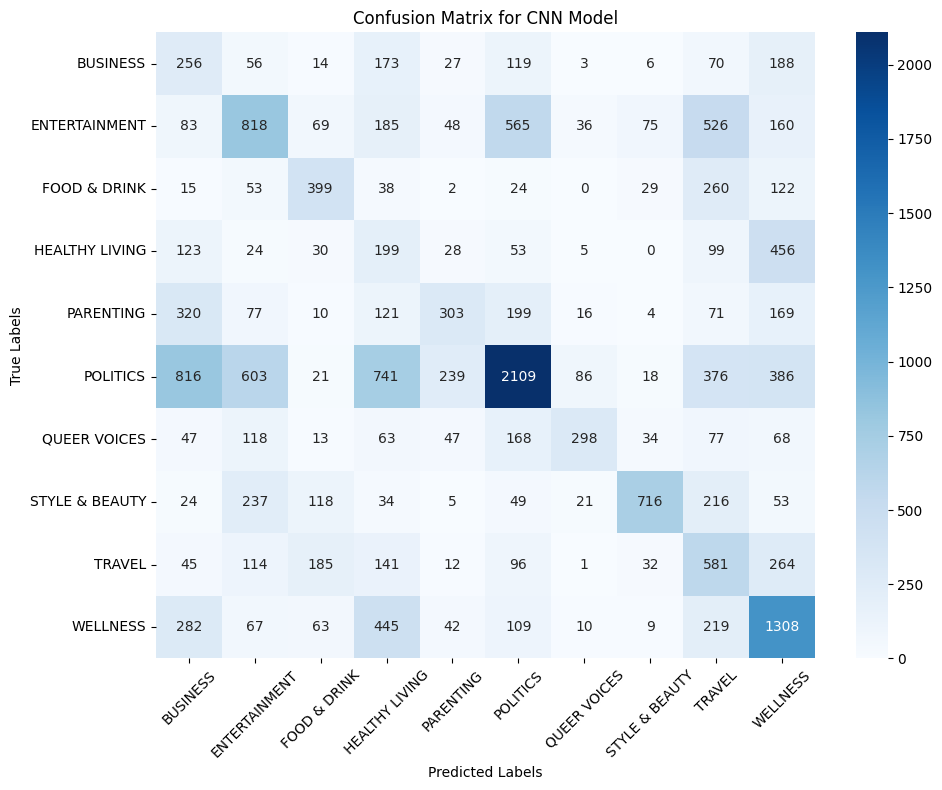

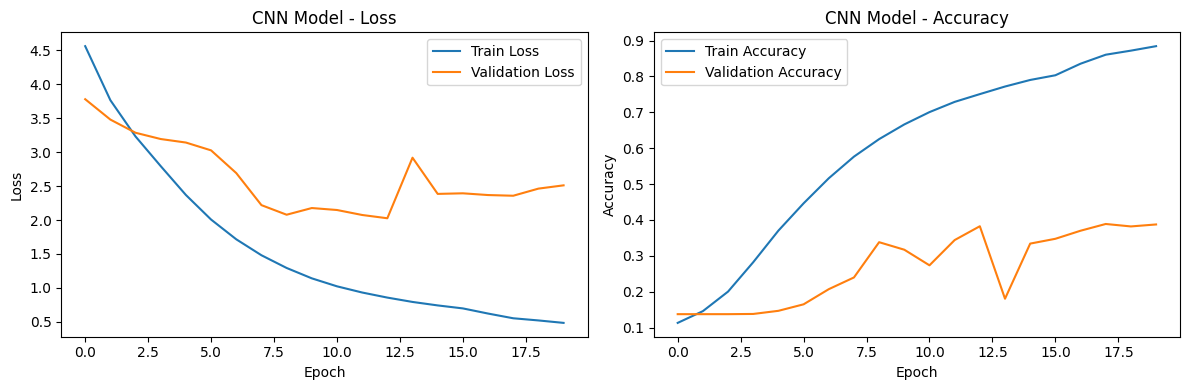


Training GRU_Attention model...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - loss: 2.8288 - sparse_categorical_accuracy: 0.1965 - val_loss: 2.7619 - val_sparse_categorical_accuracy: 0.2556 - learning_rate: 3.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - loss: 2.0369 - sparse_categorical_accuracy: 0.4662 - val_loss: 2.4261 - val_sparse_categorical_accuracy: 0.4486 - learning_rate: 3.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 1.5780 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.8542 - val_sparse_categorical_accuracy: 0.6440 - learning_rate: 3.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - loss: 1.3029 - sparse_categorical_accuracy: 0.6799 - val_loss: 1.4056 - val_sparse_categorical_accuracy: 0.6468 - learning_rate: 3.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 1.1284 - sparse_categorical_accuracy: 0.7192 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.6567 - learning_rate: 3.0000e-04
Ep

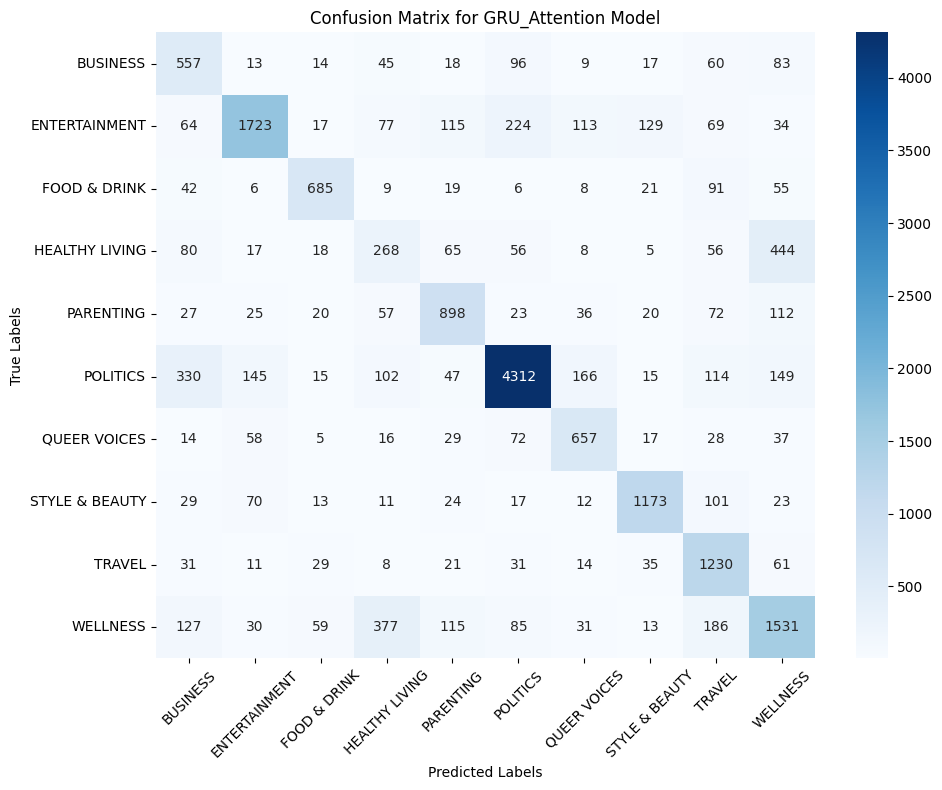

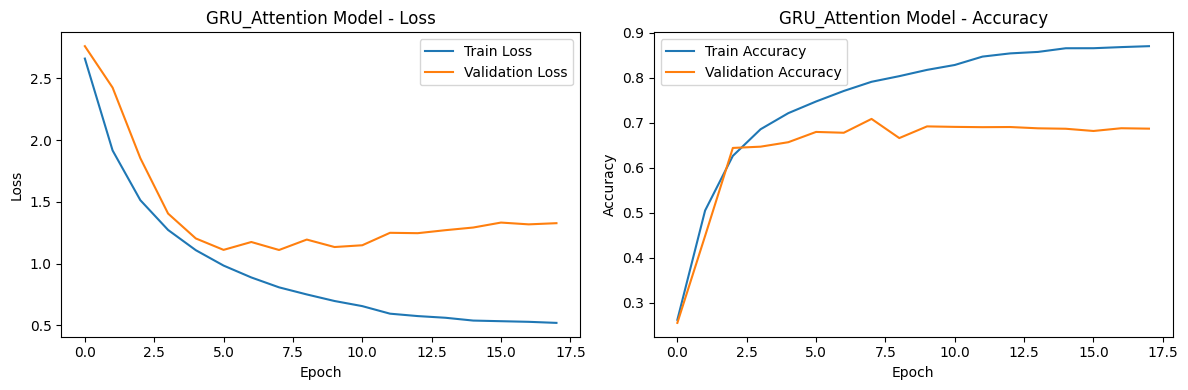


Training LSTM_Attention model...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 960ms/step - loss: 3.9275 - sparse_categorical_accuracy: 0.1500 - val_loss: 3.5765 - val_sparse_categorical_accuracy: 0.1372 - learning_rate: 3.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 904ms/step - loss: 3.0311 - sparse_categorical_accuracy: 0.3445 - val_loss: 3.2702 - val_sparse_categorical_accuracy: 0.1460 - learning_rate: 3.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 879ms/step - loss: 2.4823 - sparse_categorical_accuracy: 0.4515 - val_loss: 2.9944 - val_sparse_categorical_accuracy: 0.2234 - learning_rate: 3.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 879ms/step - loss: 2.1027 - sparse_categorical_accuracy: 0.5030 - val_loss: 2.7358 - val_sparse_categorical_accuracy: 0.2121 - learning_rate: 3.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 916ms/step - loss: 1.7877 - sparse_categorical_accuracy: 0.5662 - val_loss: 2.3314 - val_sparse_categorical_accuracy: 0.5535 - learning_rate: 3.

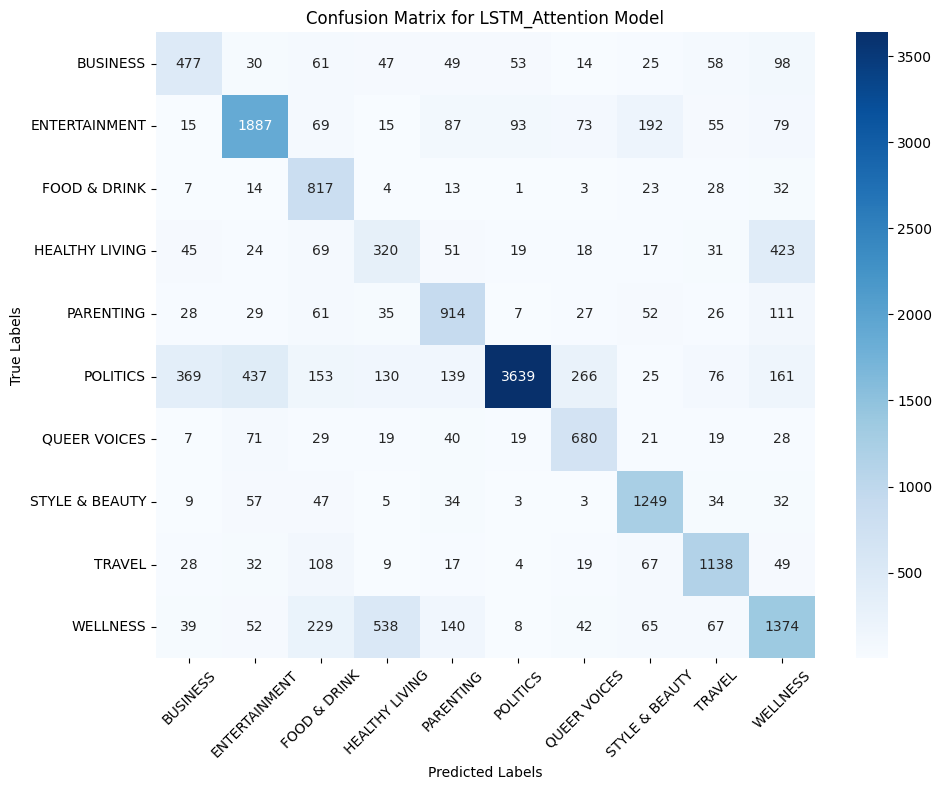

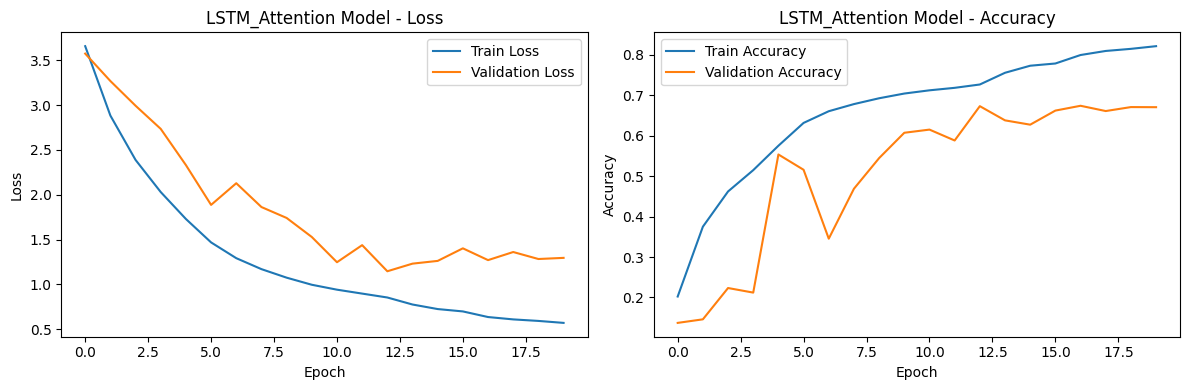


Training BiGRU model...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 86s 759ms/step - loss: 3.6046 - sparse_categorical_accuracy: 0.1153 - val_loss: 2.7220 - val_sparse_categorical_accuracy: 0.0911 - learning_rate: 3.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 794ms/step - loss: 2.8981 - sparse_categorical_accuracy: 0.1917 - val_loss: 2.6349 - val_sparse_categorical_accuracy: 0.1386 - learning_rate: 3.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 787ms/step - loss: 2.4421 - sparse_categorical_accuracy: 0.2703 - val_loss: 2.4109 - val_sparse_categorical_accuracy: 0.2482 - learning_rate: 3.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 791ms/step - loss: 2.1441 - sparse_categorical_accuracy: 0.3520 - val_loss: 2.0960 - val_sparse_categorical_accuracy: 0.4761 - learning_rate: 3.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 744ms/step - loss: 1.9196 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.7686 - val_sparse_categorical_accuracy: 0.6164 - learning_rate: 3.0000e-04


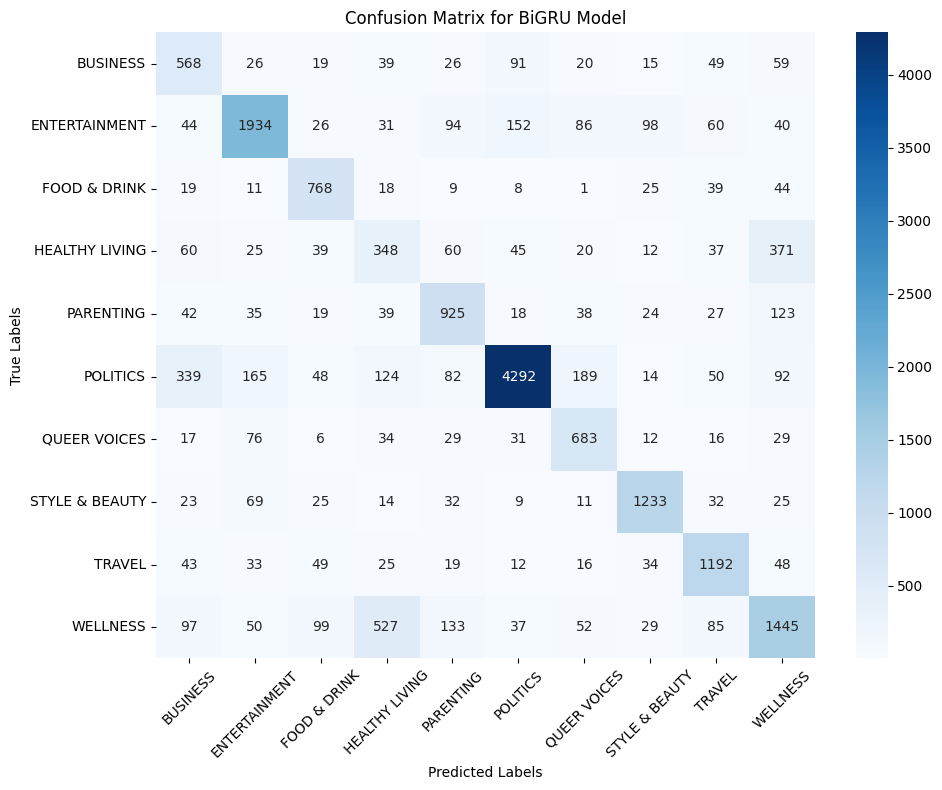

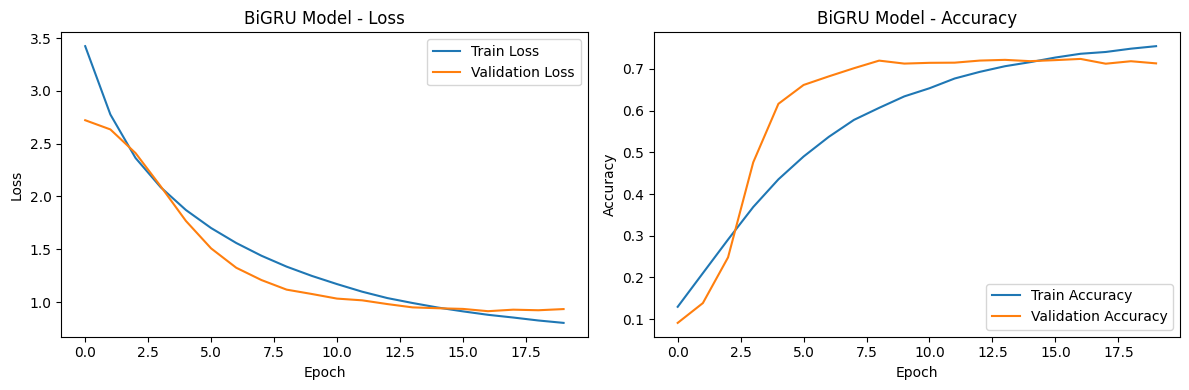

In [87]:
results = {
    "Model": [],
    "Accuracy": [],
    "Loss": [],
    "Training Time (s)": []
}
histories = {}
best_accuracy = 0.0
best_model_name = ""

for name, model in models.items():
    print(f"\nTraining {name} model...")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for {name} model: {training_time:.2f} seconds")

    histories[name] = history.history

    print(f"Evaluating {name} model...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # матрица ошибок
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 10}, cbar=True)
    plt.title(f"Confusion Matrix for {name} Model")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(histories[name]['loss'], label='Train Loss')
    plt.plot(histories[name]['val_loss'], label='Validation Loss')
    plt.title(f'{name} Model - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(histories[name]['sparse_categorical_accuracy'], label='Train Accuracy')
    plt.plot(histories[name]['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} Model - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    results["Model"].append(name)
    results["Loss"].append(loss)
    results["Accuracy"].append(accuracy)
    results["Training Time (s)"].append(training_time)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name


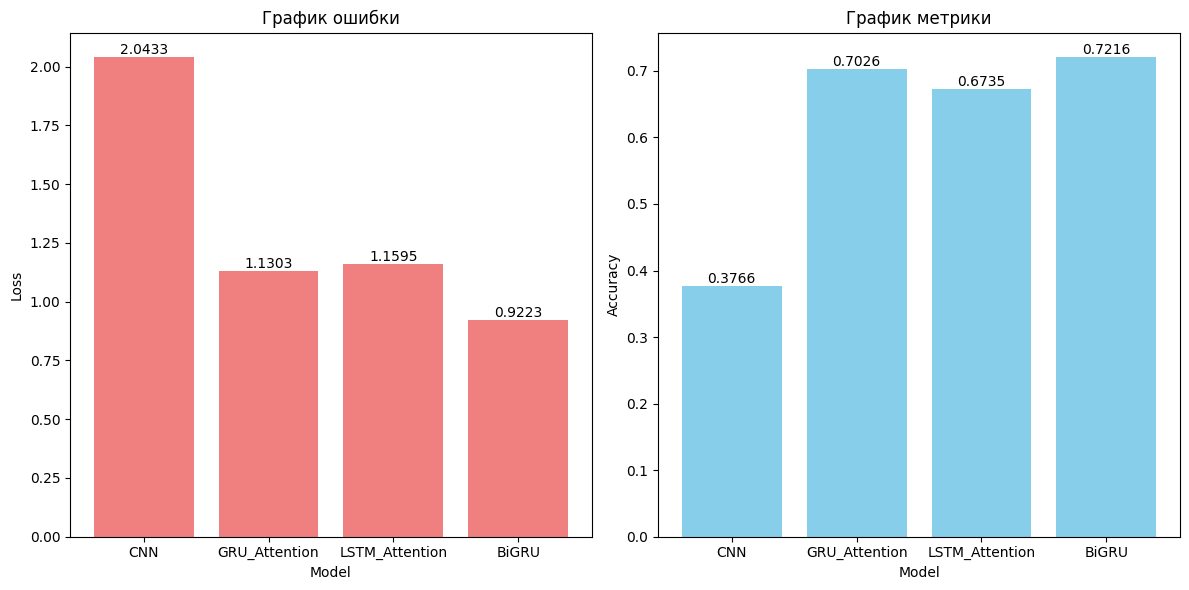


Best model: BiGRU (Accuracy: 0.7216)


In [88]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars_loss = plt.bar(results["Model"], results["Loss"], color='lightcoral')
for bar, loss in zip(bars_loss, results["Loss"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{loss:.4f}', ha='center', va='bottom')
plt.title('График ошибки')
plt.xlabel('Model')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
bars_acc = plt.bar(results["Model"], results["Accuracy"], color='skyblue')
for bar, acc in zip(bars_acc, results["Accuracy"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{acc:.4f}', ha='center', va='bottom')
plt.title('График метрики')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f"\nBest model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

## Вывод

Несмотря на большое количество слоев, сверточная нейронная сеть не может уловить все нужные закономерности и показывает на том же количетве эпох результат хуже, чем рекурентные нейронные сети.

| Модель  | Время обучения | Количество слоев | Особенности | Accuracy |
| --- | --- | --- | --- | --- |
| model_cnn | 389,09 | 4 сверточных слоя| Сверточная нейронная сеть, | 0.37 |
| model_gru_attention | 2303,94 | 2 слоя GRU| Рекурентная нейронная сеть, используется GRU и слой внимания | 0.70 |
| model_lstm_attention | 1867,83 | 1 двунаправленный слой LSTM| Рекурентная нейронная сеть, используется двунаправленный слой LSTM  и механизм внимания | 0.67|
| model_bigru | 1546,16 | 2 стоя BiGRU| Рекурентная нейронная сеть. Используются слои BiGRU возвращающие промежутоные и последние состаяния | 0.72 |